In [1]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify

client = MongoClient('mongodb://localhost:27017/')
meu_banco = client['imobiliaria']
casas = meu_banco['casas']

In [9]:
# eliminando linhas em que o campo 'qte_quartos' era preenchido por um datetime

df = pd.read_excel('HousesInfo.xlsx')
df.columns = ['qte_banheiros', 'qte_quartos', 'area', 'cep', 'preco']

drop_these_indexes = []
for i in range(0, len(df.index)):
    if df.iloc[i]['qte_quartos'] not in [1, 2, 3, 4, 5, 6, 7, 8, 9, '3.25']:
        drop_these_indexes.append(i)
        
df = df.drop(drop_these_indexes)

# ESTE BLOCO ENVIA OS DADOS PARA O BANCO
# criei o banco e a collection pelo Compass

#cria dataframe com o excel 'HousesInfo.xlsx', adiciona cabeçalho, tranforma seus campos em string

df.columns = ['qte_banheiros', 'qte_quartos', 'area', 'cep', 'preco']
for i in df.columns:
    exec("df['{}'].astype(str)".format(i))

# insere dados do dataframe na collection casas

insert_1 = casas.insert_many(df.to_dict(orient = 'records')) 

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


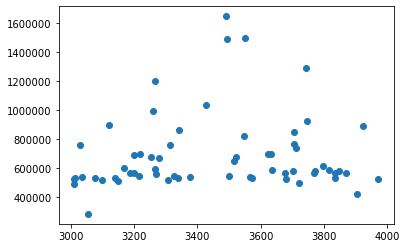

127.0.0.1 - - [27/Feb/2020 13:23:07] "GET /area/3000/4000 HTTP/1.1" 200 -


In [2]:
# EX.1

# Criar endpoint de get, que deve selecionar os dados dentro de um intervalo de area, plotar o gráfico de 
# dispersão em que o eixo x é a área e o eixo y o preco e retornar o json com esses dados; 

app = Flask(__name__)
@app.route("/area/<y>/<x>", methods = ['GET'])

def area(y, x):
    
    doc_1 = casas.find({"$and":[{"area":{"$lt":int(x)}}, {"area":{"$gt":int(y)}}]})
    df = pd.DataFrame(doc_1)
    df = df.drop(columns = ['_id'])
    
    plt.scatter(df['area'], df['preco'])
    plt.show()
    
    return jsonify(df.to_dict()), 200

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


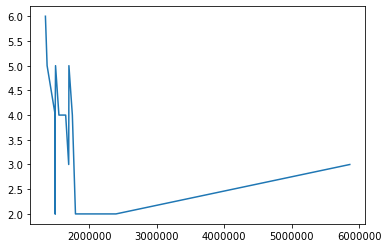

127.0.0.1 - - [27/Feb/2020 13:23:21] "GET /top15 HTTP/1.1" 200 -


In [3]:
# EX.2

# Criar endpoint de get, que deve selecionar os 15 dados com maior preco em ordem decrescente, plotar o 
# gráfico de linha em que o eixo x é o preco e o eixo y a qte_quartos e retornar o json com esses dados; 

app = Flask(__name__)

@app.route("/top15", methods = ['GET'])

def top15():
    
    doc_2 = casas.find().sort('preco', -1).limit(15)
    df_2 = pd.DataFrame(doc_2)
    df_2 = df_2.drop(columns = ['_id'])
    
    plt.plot(df_2['preco'], df_2['qte_quartos'])
    plt.show()
    
    return jsonify(df_2.to_dict()), 200
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


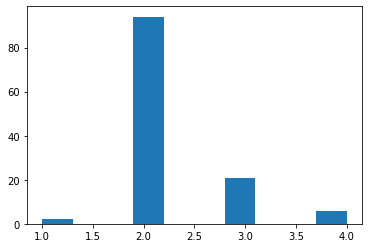

127.0.0.1 - - [27/Feb/2020 13:23:39] "GET /banheiros/3 HTTP/1.1" 200 -


In [4]:
# EX.3

# Criar endpoint de get, que deve selecionar todos os dados com determinada quantidade de qte_banheiros, 
# plotar o gráfico de barra em que o eixo x é o qte_banheiros e o eixo y a qte_quartos e retornar o json com 
# esses dados; 

app = Flask(__name__)
@app.route("/banheiros/<qte>", methods = ['GET'])

def delete(qte):
    
    doc_3 = casas.find({'qte_banheiros':int(qte)})
    df_3 = pd.DataFrame(doc_3)
    df_3 = df_3.drop(columns = ['_id'])
    
    plt.hist(df_3['qte_quartos'])
    plt.show()
    
    return jsonify(df_3.to_dict()), 200

app.run()

In [5]:
# EX.4

# Criar endpoint de put, que atualize os dados pelo cep;

app = Flask(__name__)

@app.route("/update", methods = ['PUT'])

def update():
    
    post_args = request.json
        
    if "cep" not in post_args:
        return "O cep não foi informado no dado recebido.", 400
    
    find_query = {'cep':post_args['cep']}
    
    if "qte_quartos" in post_args:
        set_value_quartos = {'$set':{'qte_quartos':post_args['qte_quartos']}}
        casas.update_one(find_query, set_value_quartos)
    
    if "qte_banheiros" in post_args:
        set_value_banheiros = {'$set':{'qte_banheiros':post_args['qte_banheiros']}}
        casas.update_one(find_query, set_value_banheiros)
        
    if "area" in post_args:
        set_value_area = {'$set':{'area':post_args['area']}}
        casas.update_one(find_query, set_value_area)
        
    if "preco" in post_args:
        set_value_preco = {'$set':{'preco':post_args['preco']}}
        casas.update_one(find_query, set_value_preco)
    
    return 'sucesso', 200

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Feb/2020 13:24:09] "PUT /update HTTP/1.1" 200 -


In [6]:
#Criar endpoint de delete, que delete os dados pelo cep;

app = Flask(__name__)
@app.route("/del/<cep>", methods = ['DELETE'])

def delete(cep):

    try:
        casas.delete_one({"cep":int(cep)})
        return 'item de cep {} deletado'.format(cep), 200
    
    except:
        return 'Não foi possível fazer o DELETE em casas', 500

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [27/Feb/2020 13:24:35] "DELETE /del/36372 HTTP/1.1" 200 -
